# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис, позволяющий пользователям редактировать и дополнять описания товаров, подобно вики-сообществам. Клиенты могут предлагать свои правки и комментировать изменения других пользователей. Для обеспечения качественного взаимодействия и предотвращения токсичных комментариев, магазину необходим инструмент, который будет автоматически находить и отправлять такие комментарии на модерацию.

**Ожидаемый результат проекта**

В рамках данного проекта необходимо обучить модель, способную классифицировать комментарии как позитивные или негативные. В распоряжении имеется набор данных с разметкой о токсичности правок.

**Цель проекта** — построить модель с метрикой качества F1 не менее 0.75.

**Инструкция по выполнению проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [82]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import timeit

# загружаем необходимые классы и функции для подготовки текста
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')

# загружаем классы для подготовки данных, для кросс-валидации и поиска лучшей модели
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# импортируем функцию для расчета f1 и вызова отчетов по результатам классификации
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# установим палетку для графиков
sns.set_palette('Set2')

# установим значения для констант
TEST_SIZE = 0.25
RANDOM_STATE = 12

# отключим warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Подготовка

### Загрузка и описание данных

In [8]:
# загружаем данные
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [9]:
# выведем первые пять строк датафрейма
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [10]:
# выведем информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


В этом датасете хранятся следующие данные:
- text: Текст комментария или поста.
- toxic: Значение бинарной переменной, указывающее на токсичность текста (0 - нетоксичный, 1 - токсичный).

Проверим какое соотношение у токсичных и нетоксичных комментариев.

In [11]:
# выведем удельные веса целевого признака
data['toxic'].value_counts(1).round(3)*100

0    89.8
1    10.2
Name: toxic, dtype: float64

В датасете:
- 89.8% нетоксичных записей.
- 10.2% токсичных записей.

Это означает, что большинство записей в датасете нетоксичны, и только небольшая часть является токсичной.

Посмотрим на это соотношение на круговой диаграмме.

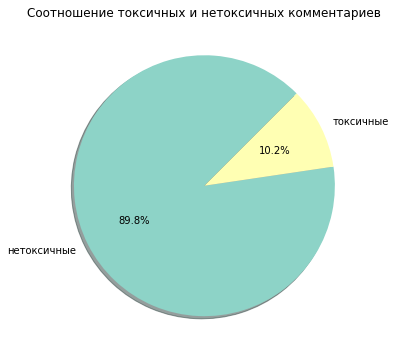

In [12]:
# строим круговую диаграмму
data['toxic'].value_counts().round(3).plot(kind='pie',
                                           labels=['нетоксичные', 'токсичные'],  # переименовываем метки категорий
                                           autopct='%1.1f%%',  # указываем формат подписей
                                           shadow=True,  # включаем тень для диаграммы
                                           startangle=45,  # устанавливаем начальный угол
                                           ylabel='',  # убираем метку оси Y
                                           colors=sns.color_palette('Set3'), # используем цветовую палитру Set3 
                                           figsize=(9, 6)) # устанавливаем размер круговой диаграммы
plt.title(f'Соотношение токсичных и нетоксичных комментариев') # заголовок диаграммы
plt.show()

Наш датасет в значительной степени несбалансирован. Соотношение нетоксичных комментариев к токсичным составляет примерно 9:1. Это может повлиять на точность модели, поэтому важно учитывать это при обучении и настройке гиперпараметров.

Приступим к предобработке текста.

### Лемматизация и очистка текста

Чтобы подготовить текст для обучения моделей лемматизируем его и очистим от небуквенных символов.

In [13]:
# функция get_wordnet_pos позволяет преобразовывать POS-теги слов в соответствующие теги WordNet
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [14]:
# напишем функцию для подготовки текста
def lemmatize_clear_text(text):
    # заменяем все небуквенные символы пробелами в тексте
    clear_text_with_gaps = re.sub(r'[^a-zA-Z]', ' ', text) 
    # удаляем лишние пробелы в тексте
    clear_text_without_gaps = ' '.join(nltk.word_tokenize(clear_text_with_gaps.lower())) 
    
    # лемматизируем каждое слово в тексте
    lemmatizer = WordNetLemmatizer() # создаем объект лемматизатора
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(clear_text_without_gaps)] 
    
    # соединяем лемматизированные слова в строку
    lemmatized_text = ' '.join(lemmatized_words) 
    
    return lemmatized_text # возвращаем очищенный текст без пробелов

In [15]:
# применение функции для обработки текстов
data['lemm_text'] = data['text'].apply(lemmatize_clear_text)

In [16]:
# выведем результат работы функции
# очищенный и лемматизированный при помощи POS-тегов текст
data['lemm_text'].head()

0    explanation why the edits make under my userna...
1    d aww he match this background colour i m seem...
2    hey man i m really not try to edit war it s ju...
3    more i can t make any real suggestion on impro...
4    you sir be my hero any chance you remember wha...
Name: lemm_text, dtype: object

Далее подготовим текст в обучению моделей.

### Подготовка текста к обучению моделей

На этом шаге необходимо:
- разделить выборку на обучающую и тестовую,
- исключить из выборок стоп-слова на английском языке,
- получить матрицы tf-idf для обучающих и тестовых данных.

In [17]:
# загружаем лемматизированный текст из датасета в переменную X
X = data['lemm_text']

# загружаем целевой признак (токсичность) из датасета в переменную y
y = data['toxic']

# разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)

In [18]:
# выводим размерность обучающей выборки
print(X_train.shape)

# выводим размерность тестовой выборки
print(X_test.shape)

(119469,)
(39823,)


In [19]:
# создаем список стоп-слов на английском языке
stopwords = list(set(nltk_stopwords.words('english')))

In [20]:
# создаем объект TfidfVectorizer с использованием стоп-слов
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [21]:
# обучаем TfidfVectorizer и применяем его к обучающей выборке
tf_idf_train = count_tf_idf.fit_transform(X_train)

# применяем TfidfVectorizer к тестовой выборке
tf_idf_test = count_tf_idf.transform(X_test)

In [22]:
# выводим размерность преобразованных данных для обучающей выборки
print(tf_idf_train.shape)

# выводим размерность преобразованных данных для тестовой выборки
print(tf_idf_test.shape)

(119469, 127743)
(39823, 127743)


Размерность итоговых данных большая - векторизатор добыл 128 тысяч словоформ. Это чрезвычайно много. Например, в Оксфордском словаре английского языка содержится около 171 476 актуальных слов для нашего времени. 

Вероятно, текст нуждается в лучшей предобработке. Но на данный момент остановимся на минимально работоспособном прототипе решения и посмотрим как обучаются модели и какой дают результат на таких данных.

**ОБЩИЙ ВЫВОД ПО ПОДГОТОВКЕ ДАННЫХ**

На этапе подготовки мы: 
- Загрузили датасет;
- Установили, что в нем содержатся тексты на английском языке. Всего около 150 тыс. сообщений;
- Проанализировали целевой признак - токсичность текста. Определили, что в датасете намного больше обычных сообщений, чем токсичных.
- Провели предобработку текста - очистили от небуквенных символов и лемматизировали слова в тексте;
- Разбили выборку на обучающую и тестовую;
- Привели текстовые данные к формату TF-IDF, то есть посчитали частоту встречаемости слов в каждом из текстов и представили эти результаты в виде матрицы, устранив при этом стоп-слова.

## Обучение и анализ моделей

Обучим три класса моделей:
- логистическую регрессию,
- дерево решений,
- метод ближайших соседей.

Поскольку данные крайне несбалансированы, необходимо учесть это обстоятельство и при инициализации моделей указать параметр class_weight.

Эта метрика подходит для ситуаций, когда классы сильно несбалансированы и важно учитывать различия в частоте классов. Она учитывает веса каждого класса, которые пропорциональны их частоте. Это позволяет более точно оценить производительность модели в условиях несбалансированных данных.

Будем придерживаться такого плана:
- измерим качество каждой из моделей на кросс-валидационной выборке (методом cross_val_score),
- сравним характеристики моделей - метрику f1 на кросс-валидационной выборке и время обучения,
- выберем лучшую модель и построим прогноз на тестовых данных по ней,
- осуществим расчет метрики f1 на тестовых данных и сравним результаты с тренировочными данными.

Ниже представлены модели, которые будут использоваться для классификации данных.

**Логистическая регрессия (LogisticRegression)** и **Дерево решений (DecisionTreeClassifier)**:
- Устанавлено случайное состояние для воспроизводимости результатов.
- Модель использует сбалансированный вес классов для учета несбалансированности данных.

**Метод ближайших соседей (KNeighborsClassifier)**: 

- Устанавлено количество соседей (n_neighbors) равным 100.

In [23]:
# создаём модель для логистической регрессии
model_lr = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

# создаём модель для дерева решений
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

# создаём модель для метода ближайших соседей
model_knn = KNeighborsClassifier(n_neighbors=100)

Далее напишем функцию, которая позволяет оценить производительность модели на обучающей выборке, учитывая как точность (f1), так и время обучения.

In [24]:
# запишем функцию для оценки работы моделей
def model_pred(model):
    
    # фиксируем время начала обучения
    start_train_time = timeit.default_timer()
    
    # проводим кросс-валидацию с использованием cross_val_score    
    scores = cross_val_score(model,
                             tf_idf_train, 
                             y_train,
                             scoring='f1', 
                             cv=3, 
                             verbose=3,
                             n_jobs=-1) 
    
    # фиксируем время окончания обучения
    end_train_time = timeit.default_timer() 
    
    # рассчитываем продолжительность обучения
    train_time = end_train_time - start_train_time
    
    # сохраняем среднее значение метрики по кросс-валидационной выборке 
    train_f1 = scores.mean()
    
    # функция вернет метрику f1 и время обучения на кросс-валидационной выборке
    return train_f1, train_time

In [25]:
# оцениваем производительность модели логистической регрессии
train_f1_lr, train_time_lr = model_pred(model_lr)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.741) total time=  37.0s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   37.0s remaining:    0.0s


[CV] END ................................ score: (test=0.749) total time=  42.0s


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV] END ................................ score: (test=0.743) total time=  28.8s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished


In [26]:
# оцениваем производительность модели дерева решений
train_f1_dt, train_time_dt = model_pred(model_dt)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.655) total time= 1.2min


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] END ................................ score: (test=0.622) total time= 1.2min


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


[CV] END ................................ score: (test=0.647) total time= 1.2min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.6min finished


In [27]:
# оцениваем производительность модели K-ближайших соседей
train_f1_knn, train_time_knn = model_pred(model_knn)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.369) total time= 2.2min


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


[CV] END ................................ score: (test=0.486) total time= 2.2min


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  4.4min remaining:    0.0s


[CV] END ................................ score: (test=0.394) total time= 2.2min


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.6min finished


Посмотрим на результаты.

In [28]:
# составим датафрейм с ключевыми метриками моделей
model_results = pd.DataFrame({'train_f1' : [train_f1_lr,
                                            train_f1_dt,
                                            train_f1_knn],
                              'train_time' : [train_time_lr,
                                              train_time_dt,
                                              train_time_knn]
                             },
                            index=['Логистическая регрессия', 
                                   'Дерево решений',
                                   'K-ближайших соседей']
                            )

In [29]:
# посмотрим на результаты
model_results.round(2)

,train_f1,train_time
Логистическая регрессия,0.74,107.82
Дерево решений,0.64,215.74
K-ближайших соседей,0.42,395.31


**Анализ результатов оценки метрик на кросс-валидационной выборке**

- Логистическая регрессия:

    Высокая точность (train_f1 = 0.74) при относительно коротком времени обучения. Это свидетельствует о хорошей производительности модели с точки зрения точности и скорости обучения.


- Дерево решений:
    
    Средняя точность (train_f1 = 0.64) при более длительном времени обучения. Это может указывать на то, что модель требует больше времени для обучения, но всё же обеспечивает неплохую точность.


- K-ближайших соседей:
    
    Низкая точность (train_f1 = 0.42) при самом длительном времени обучения. Это может означать, что модель требует больше времени для обучения и не обеспечивает высокую точность.


**Вывод:**
Логистическая регрессия представляется наиболее подходящей моделью для использования в данном случае, учитывая её высокую точность и быстрое время обучения. Однако на кросс-валидационной выборке мы получили метрику f1 меньше 0,75.

Далее подберем гиперпараметры для логистической регрессии через рандомизированный поиск с кросс-валидацией, чтобы выполнить требование по проекту.

In [51]:
# определение параметров для поиска
param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'lbfgs', 'saga']
}

In [52]:
# создание объекта RandomizedSearchCV
random_search = RandomizedSearchCV(model_lr, 
                                   param_grid_lr, 
                                   scoring='f1', 
                                   cv=3,
                                   verbose=3,
                                   n_jobs=-1)

In [53]:
# обучение модели с использованием RandomizedSearchCV
random_search.fit(tf_idf_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END ............C=0.1, penalty=l1, solver=liblinear; total time=   0.7s
[CV 2/3] END ............C=0.1, penalty=l1, solver=liblinear; total time=   0.7s
[CV 3/3] END ............C=0.1, penalty=l1, solver=liblinear; total time=   0.7s
[CV 1/3] END .........C=0.1, penalty=elasticnet, solver=saga; total time=   0.0s
[CV 2/3] END .........C=0.1, penalty=elasticnet, solver=saga; total time=   0.0s
[CV 3/3] END .........C=0.1, penalty=elasticnet, solver=saga; total time=   0.0s
[CV 1/3] END .................C=0.1, penalty=l1, solver=saga; total time=  15.3s
[CV 2/3] END .................C=0.1, penalty=l1, solver=saga; total time=  15.2s
[CV 3/3] END .................C=0.1, penalty=l1, solver=saga; total time=  15.4s
[CV 1/3] END ..........C=1, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV 2/3] END ..........C=1, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV 3/3] END ..........C=1, penalty=elasticnet, 

RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(class_weight='balanced',
                                                random_state=12),
                   n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['liblinear', 'lbfgs',
                                                   'saga']},
                   scoring='f1', verbose=3)

In [70]:
# получение оценки метрики качества, лучших параметров и модели
best_score = random_search.best_score_
best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [76]:
# оценка метрики лучшей модели
best_score.round(4)

0.7574

В результате рандомизированного поиска нам удалось получить на кросс-валидационной выборке оценку f1 выше 0,75.

Проверим метрику на тестовой выборке.

In [62]:
# лучшая модель после рандомизированного поиска
best_model

LogisticRegression(C=10, class_weight='balanced', random_state=12)

In [68]:
# лучшие гиперпараметры
best_params

{'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}

Лучшей моделью оказалась логистическая регрессия с параметрами:

- C=10:
C определяет силу регуляризации. Чем меньше значение C, тем сильнее регуляризация. В данном случае C=10, что означает умеренную регуляризацию.

- solver='lbfgs':
lbfgs (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) является эффективным оптимизатором, который использует приближение градиента для ускорения вычислений. Он хорошо подходит для больших и сложных моделей.

- penalty='l2':
L2-регуляризация помогает избежать переобучения, штрафуя большие веса. Это делает модель более устойчивой к шуму в данных.

Модель LogisticRegression с параметрами C=10, solver=‘lbfgs’, penalty=‘l2’ является хорошо сбалансированной и устойчивой к переобучению. Она подходит для работы с несбалансированными данными и обеспечивает хорошую производительность благодаря умеренной регуляризации и эффективному оптимизатору.

In [63]:
# получим предсказания по лучшей модели
y_pred = best_model.predict(tf_idf_test)

In [74]:
# вычислим метрику F1 на тестовых данных
best_test_f1 = f1_score(y_test, y_pred)

In [75]:
# лучшая метрика на тестовых данных
best_test_f1.round(4)

0.7567

На тестовой выборке также видим оценку f1 выше 0,75.

Мы выполнили требование по качеству модели.

**Анализ метрики на тестовой выборке по лучшей модели**

Значение метрики F1 на тестовой выборке по логистической регрессии составило 0.76.
Аналогичное значение мы получили на кросс-валидационной выборке.

Это значение показывает, что модель имеет хорошую общую производительность, учитывая как точность, так и полноту для обоих классов. 

Учитывая сильную несбалансированность данных, необходимо удостоверится, нуждается ли модель в улучшении для более точного распознавания токсичных записей.

Для этого построим матрицу ошибок и отчет по классификации.

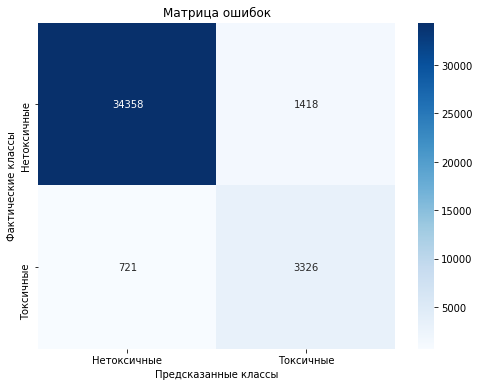

In [83]:
# матрица ошибок
confusion_matrix = confusion_matrix(y_test, y_pred)

# преобразование матрицы в формат для seaborn
labels = ['Нетоксичные', 'Токсичные']
data = [
    [confusion_matrix[0][0], confusion_matrix[0][1]],
    [confusion_matrix[1][0], confusion_matrix[1][1]]
]

# визуализация тепловой карты
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Предсказанные классы')
plt.ylabel('Фактические классы')
plt.title('Матрица ошибок')
plt.show()

**Анализ матрицы ошибок**
* True Positive (TP):
    Количество правильно предсказанных токсичных записей: 3326.

* False Positive (FP):
    Количество ошибочно предсказанных токсичных записей: 1418.

* True Negative (TN):
    Количество правильно предсказанных нетоксичных записей: 34358.

* False Negative (FN):
    Количество ошибочно предсказанных нетоксичных записей: 721.
    
**Вывод:** Наглядно видно, что количество ошибок False Positive (неправильный класс "1") по отношению к правильно предсказанным токсичным записям намного больше, чем ошибок (неправильный класс "0") по отношению к ошибочно предсказанным нетоксичным записям.

Рассмотрим более подробно, как определяются эти классы, но для сопоставления будем использовать относительные метрики.

In [85]:
# выведем на экран отчет по классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     35776
           1       0.70      0.82      0.76      4047

    accuracy                           0.95     39823
   macro avg       0.84      0.89      0.86     39823
weighted avg       0.95      0.95      0.95     39823



**Анализ отчета по классификации**

* Precision (Точность):
    - Для класса 0 (нетоксичные записи): 0.98.
    - Для класса 1 (токсичные записи): 0.70.


* Recall (Полнота):
    - Для класса 0: 0.96.
    - Для класса 1: 0.82.


* F1-Score (F1-мера):
    - Для класса 0: 0.97.
    - Для класса 1: 0.76.

**Выводы и закономерности**

- *Высокая точность для нетоксичных записей*:

    Модель показывает высокую точность для большинства записей, что свидетельствует о её способности правильно классифицировать нетоксичные записи.


- *Низкая точность для токсичных записей*:
    
    Для токсичных записей точность ниже, что может быть связано с их меньшей долей в данных.


- *Высокая полнота для токсичных записей*:
    
    Полнота для токсичных записей высокая, что означает, что модель хорошо распознает токсичные записи среди всех токсичных записей в данных.


Сильная несбалансированность данных влияет на точность и полноту модели. Модель лучше справляется с большинством нетоксичных записей, но менее эффективна для токсичных записей. Для улучшения результатов можно рассмотреть методы балансировки данных, чтобы улучшить точность для токсичных записей.

**ОБЩИЙ ВЫВОД ПО ОБУЧЕНИЮ И ТЕСТИРОВАНИЮ МОДЕЛЕЙ**

В рамках раздела "Обучение моделей" были реализованы следующие шаги:

1. **Создание моделей**:
   - **Логистическая регрессия (LogisticRegression)**:
     - Установлено случайное состояние для воспроизводимости результатов.
     - Используется сбалансированный вес классов для учета несбалансированности данных.

   - **Дерево решений (DecisionTreeClassifier)**:
     - Установлено случайное состояние для воспроизводимости.
     - Используется сбалансированный вес классов.

   - **Метод ближайших соседей (KNeighborsClassifier)**:
     - Установлено количество соседей (n_neighbors) равным 100.
     

2. **Измерение качества моделей на кросс-валидационной выборке**:
   - Для каждой модели была проведена кросс-валидация с использованием `cross_val_score`.
   - Метрика `f1` использовалась для учета токсичного класса.


3. **Сравнение характеристик моделей**:
   - Были рассчитаны метрика `f1` и время обучения для каждой модели.
   - Логистическая регрессия показала высокую точность при относительно коротком времени обучения.
   - Дерево решений продемонстрировало среднюю точность при более длительном времени обучения.
   - Метод ближайших соседей показал низкую точность при самом длительном времени обучения.


4. **Выбор лучшей модели**:
   - Логистическая регрессия была выбрана как наиболее подходящая модель, учитывая её высокую точность и быстрое время обучения.
   - После подбора гиперпараметров при помощи рандомизированного поиска на кросс-валидационной выборке было улучшено качество модели.


5. **Построение прогноза на тестовых данных**:
   - Прогноз был построен на тестовых данных с использованием выбранной модели.


6. **Расчет метрики f1 на тестовых данных**:
   - Значение метрики f1 на тестовой выборке по логистической регрессии составило 0.76, что соответствует значению на кросс-валидационной выборке.


Таким образом, логистическая регрессия показала себя как наиболее эффективная модель для классификации данных с учетом их несбалансированности.

## Выводы по работе

В рамках проекта были выполнены следующие ключевые этапы:

1. **Подготовка данных**:
   - Загружен датасет, содержащий около 150 тыс. сообщений на английском языке.
   - Проведен анализ целевого признака (токсичность текста), выявивший значительную несбалансированность данных (гораздо больше обычных сообщений, чем токсичных).
   - Выполнена предобработка текста: очистка от небуквенных символов и лемматизация слов.
   - Разделение выборки на обучающую и тестовую.
   - Приведение текстовых данных к формату TF-IDF, что позволило представить тексты в виде матрицы частот слов, устранив при этом стоп-слова.
   

2. **Обучение и тестирование моделей**:
   - Созданы три модели: логистическая регрессия (LogisticRegression), дерево решений (DecisionTreeClassifier) и метод ближайших соседей (KNeighborsClassifier).
   - Для каждой модели проведено измерение качества на кросс-валидационной выборке с использованием метрики `f1`.
   - Выполнено сравнение характеристик моделей: логистическая регрессия показала высокую точность при относительно коротком времени обучения, дерево решений продемонстрировало среднюю точность при более длительном времени обучения, а метод ближайших соседей показал низкую точность при самом длительном времени обучения.
   - Логистическая регрессия была выбрана как наиболее подходящая модель, учитывая её высокую точность и быстрое время обучения.
   - Построен прогноз на тестовых данных с использованием выбранной модели.
   - Рассчитана метрика f1 на тестовых данных, которая составила 0.76, что соответствует значению на кросс-валидационной выборке.

**ЗАКЛЮЧЕНИЕ:**

* **Лучшая модель**

    Логистическая регрессия представляется наиболее подходящей моделью для использования в данном случае, учитывая её высокую точность и относительно короткое время обучения.


* **Несбалансированность классов**

    Однако, несмотря на высокую точность, модель демонстрирует некоторые проблемы, связанные с несбалансированностью данных. Анализ матрицы ошибок показывает, что количество ошибок False Positive (неправильный класс “1”) значительно превышает количество ошибок False Negative (неправильный класс “0”). Это указывает на необходимость улучшения модели для более точного распознавания токсичных записей.
    
    
* **Рекомендации по устранению несбалансированности** 

    Для улучшения результатов можно рассмотреть методы балансировки данных, такие как SMOTE или Random Undersampling, чтобы уменьшить влияние несбалансированности на точность модели. Это позволит повысить точность для токсичных записей и улучшить общую производительность модели.